In [184]:
import pandas as pd
import re
file_path = "./Final sheet - No Name.xlsx"
excel_data = pd.ExcelFile(file_path)

In [185]:
all_med_names = excel_data.sheet_names
all_med_names.remove('Methadone 2')
print("Sheet Names:", all_med_names)

Sheet Names: ['Ameitriptyline', 'Bupropion', 'Clonazepam', 'Clonidine', 'Escitalopram', 'Fentanyl', 'Fluoxetine', 'Hydroxyzine', 'Gabapentine', 'Hydrocodone', 'ibuprofen', 'Lemotrigine', 'Methadone 1', 'Mobic { Meloxicam}', 'Morphine', 'NALTREXONE', 'Oxcarbazepine', 'Oxymorphone', 'Oxycodone', 'Remeron', 'Suboxon { Buprenorphine , Nalox', 'topamax', 'Tramadol', 'Trazodone', 'Valium { diazepam', 'Xanx']


In [205]:
med_id = {}  # {id: set of medicine names}
patient_history = {}  # {patient record number: {med_id: {'prescription_date': [list of dates], 'stop_date': string of date}}}
patient_DOB = {} # {id: timestamp of date}

for sheet_name in all_med_names:
    # print(sheet_name)
    sheet_data = excel_data.parse(sheet_name)
    sheet_data = sheet_data.dropna(how="any")

    for index, row in sheet_data.iterrows():
        prn = row["Patient Record Number"]
        if prn not in patient_history:
            patient_history[prn] = {}
        if prn not in patient_DOB:
            patient_DOB[prn] = row["DOB"]

        # Process Medication
        all_med = row["Medication"].split(";")
        for med_rec in all_med:
            med_rec = med_rec.strip()
            match = re.match(r"(\d+)\s+\((.+?)\)(?:,.*?Stop\s+([\d/]+))?", med_rec)
            if match:
                med_number = int(match.group(1))
                med_name = match.group(2).strip()
                stop_date = match.group(3) if match.group(3) else ""

                # Update med_id
                if med_number not in med_id:
                    med_id[med_number] = set([med_name])
                else:
                    med_id[med_number].add(med_name)

                # Initialize patient medication history if not present
                if med_number not in patient_history[prn]:
                    patient_history[prn][med_number] = {
                        "stop_date": stop_date,
                        "prescription_date": set([]),
                    }

        # Process Prescription
        all_pres = row["Prescription"].split(";")
        for pres_rec in all_pres:
            pres_rec = pres_rec.strip()
            match = re.match(r"(\d+)\s+\(.+?\).*?,\s*Start\s+([\d/]+)", pres_rec)
            if match:
                number = int(match.group(1))
                start_date = match.group(2)

                # Ensure medication exists in patient history before appending
                if number not in patient_history[prn]:
                    patient_history[prn][number] = {
                        "stop_date": "",
                        "prescription_date": set([]),
                    }
                patient_history[prn][number]["prescription_date"].add(start_date)


In [206]:
from collections import Counter

def normalize_name(name):
    # Normalize the name: lowercase, remove extra spaces, and special characters
    name = name.lower()
    name = re.sub(r'[^a-z0-9\s]', '', name)  # Remove non-alphanumeric characters
    name = re.sub(r'\s+', ' ', name).strip()  # Remove extra spaces
    return name

def select_most_common_name(med_dict):
    result = {}
    for med_id, names in med_dict.items():
        # Normalize all names
        normalized_names = [normalize_name(name) for name in names]

        # Count significant substrings (words or key terms)
        substring_counter = Counter()
        for name in normalized_names:
            words = name.split()
            substring_counter.update(words)

        # Sort names by the frequency of their significant substrings
        sorted_names = sorted(
            names,
            key=lambda x: sum(substring_counter[word] for word in normalize_name(x).split()),
            reverse=True
        )

        # Pick the most common name
        result[med_id] = sorted_names[0]

    return result

# Get the most common names
med_id_names = select_most_common_name(med_id)

# # Print the result
# for medid, name in most_common_names.items():
#     print(f"{medid}: {name}")
# med_id_names

# Analysis

In [228]:
from collections import defaultdict, Counter
from datetime import datetime
import pandas as pd
import statistics

# List of opioid medication IDs
weaker_opioids = {835603, 833709}
strong_opioids = {864718, 864761, 864706}
buprenorphine_opioids = {1010600, 1010604, 1307056, 1307061}
all_opioids = weaker_opioids | strong_opioids | buprenorphine_opioids

def classify_patients(patient_history, patient_DOB, med_id_names):
    # Initialize patient categories
    failed_cases = []
    success_cases = []
    still_in_process = []

    age_data = {
        "failed": [],
        "success": [],
        "in_process": []
    }
    last_prescription_years = {
        "failed": [],
        "success": [],
        "in_process": []
    }
    
    alternative_meds_summary = defaultdict(list)  # Store sequences of medicines for success cases

    for patient_id, medications in patient_history.items():
        # Collect all prescription dates and classify based on rules
        total_visits = 0
        opioid_prescriptions = []
        non_opioid_prescriptions = []

        for med_id, details in medications.items():
            # Parse prescription dates correctly
            total_visits += len(details['prescription_date'])
            parsed_dates = {datetime.strptime(date, "%m/%d/%Y") for date in details['prescription_date']}
            if med_id in all_opioids:
                opioid_prescriptions.extend(parsed_dates)
            else:
                non_opioid_prescriptions.extend(parsed_dates)

        # Sort dates for clarity
        opioid_prescriptions = sorted(opioid_prescriptions)
        non_opioid_prescriptions = sorted(non_opioid_prescriptions)

        # Determine age using the last prescription date
        last_prescription_date = max(opioid_prescriptions + non_opioid_prescriptions, default=None)
        age = None
        if last_prescription_date and patient_id in patient_DOB:
            dob = patient_DOB[patient_id]
            if not isinstance(dob, datetime):
                dob = pd.Timestamp(dob).to_pydatetime()  # Convert pandas.Timestamp to datetime if necessary
            age = (last_prescription_date - dob).days // 365

        # Rule 1: Only 1-2 visits and no opioid prescribed
        if total_visits <= 2 and not opioid_prescriptions:
            failed_cases.append(patient_id)
            if age is not None:
                age_data["failed"].append(age)
        # Rule 2: 3 or more visits with no opioids prescribed
        elif total_visits >= 3 and not opioid_prescriptions:
            success_cases.append(patient_id)
            if age is not None:
                age_data["success"].append(age)
            # Summarize alternative medicine sequence for success cases
            for med_id in medications:
                if med_id not in all_opioids:
                    alternative_meds_summary[patient_id].append((med_id, sorted(medications[med_id]['prescription_date'])))
        # Rule 3: Opioids prescribed but the two most recent prescriptions are non-opioids
        elif opioid_prescriptions:
            most_recent_opioids = opioid_prescriptions[-2:] if len(opioid_prescriptions) >= 2 else opioid_prescriptions
            most_recent_dates = sorted(opioid_prescriptions + non_opioid_prescriptions, reverse=True)[:2]
            if all(date in non_opioid_prescriptions for date in most_recent_dates):
                success_cases.append(patient_id)
                if age is not None:
                    age_data["success"].append(age)
                # Summarize alternative medicine sequence for success cases
                for med_id in medications:
                    if med_id not in all_opioids:
                        alternative_meds_summary[patient_id].append((med_id, sorted(medications[med_id]['prescription_date'])))
            else:
                still_in_process.append(patient_id)
                if age is not None:
                    age_data["in_process"].append(age)
        # Rule 4: Patients still being prescribed opioids
        else:
            still_in_process.append(patient_id)
            if age is not None:
                age_data["in_process"].append(age)

        # Record last prescription year for all relevant cases
        if last_prescription_date:
            last_year = last_prescription_date.year
            if patient_id in failed_cases:
                last_prescription_years["failed"].append(last_year)
            elif patient_id in success_cases:
                last_prescription_years["success"].append(last_year)
            elif patient_id in still_in_process:
                last_prescription_years["in_process"].append(last_year)

    # Generate and print summaries
    print("Failed Cases (1-2 visits, no opioids prescribed):", len(failed_cases))
    print("Success Cases (3+ visits, no opioids or last 2 prescriptions non-opioids):", len(success_cases))
    print("Still In Process (currently prescribed opioids):", len(still_in_process))

    print("\nAge Analysis:")
    for category, ages in age_data.items():
        if ages:
            print(f"{category.capitalize()} - Average Age: {sum(ages) / len(ages):.2f}, Median Age: {statistics.median(ages):.2f}, Std Dev: {statistics.stdev(ages):.2f}, Min Age: {min(ages)}, Max Age: {max(ages)}")
        else:
            print(f"{category.capitalize()} - No data available.")

    print("\nLast Prescription Year Analysis:")
    for category, years in last_prescription_years.items():
        if years:
            year_counts = Counter(years)
            print(f"{category.capitalize()} - Year Occurrences:")
            for year, count in sorted(year_counts.items()):  # Add `sorted` here
                print(f"  {year}: {count} occurrences")
        else:
            print(f"{category.capitalize()} - No data available.")

    print("\nAlternative Medicines Summary for Success Cases:")
    for patient_id, meds in alternative_meds_summary.items():
        print(f"Patient {patient_id}:")
        for med_id, dates in meds:
            print(f"  {med_id_names.get(med_id, 'Unknown')} ({med_id}) - Dates: {dates}")


    return age_data, last_prescription_years, alternative_meds_summary

age_data, last_prescription_years, alternative_meds_summary = classify_patients(patient_history, patient_DOB, med_id_names)

Failed Cases (1-2 visits, no opioids prescribed): 170
Success Cases (3+ visits, no opioids or last 2 prescriptions non-opioids): 805
Still In Process (currently prescribed opioids): 139

Age Analysis:
Failed - Average Age: 49.41, Median Age: 50.50, Std Dev: 13.06, Min Age: 22, Max Age: 89
Success - Average Age: 51.04, Median Age: 51.00, Std Dev: 13.47, Min Age: 21, Max Age: 95
In_process - Average Age: 51.51, Median Age: 53.00, Std Dev: 14.13, Min Age: 23, Max Age: 87

Last Prescription Year Analysis:
Failed - Year Occurrences:
  2012: 4 occurrences
  2013: 7 occurrences
  2014: 10 occurrences
  2015: 36 occurrences
  2016: 19 occurrences
  2017: 28 occurrences
  2018: 19 occurrences
  2019: 8 occurrences
  2020: 12 occurrences
  2021: 7 occurrences
  2022: 10 occurrences
  2023: 8 occurrences
  2024: 2 occurrences
Success - Year Occurrences:
  2012: 11 occurrences
  2013: 62 occurrences
  2014: 53 occurrences
  2015: 50 occurrences
  2016: 92 occurrences
  2017: 108 occurrences
  2018

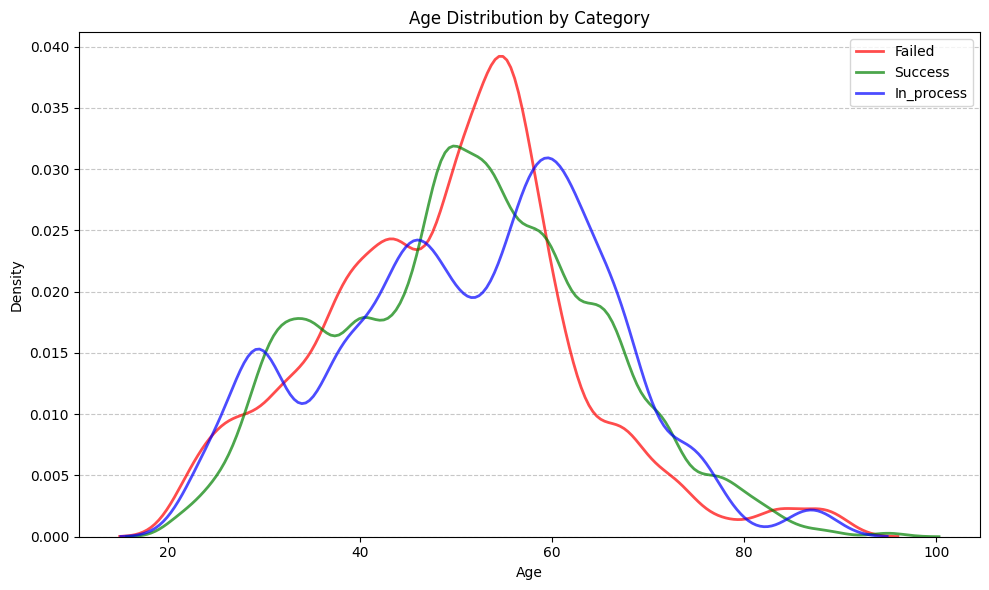

In [233]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot KDE for age data
def plot_age_distribution_kde(age_data):
    plt.figure(figsize=(10, 6))

    # Define colors for each category
    colors = {
        "failed": "red",
        "success": "green",
        "in_process": "blue"
    }

    # Plot KDE for each category
    for category, ages in age_data.items():
        if ages:
            sns.kdeplot(
                ages, 
                bw_adjust=0.5,  # Bandwidth adjustment for smoother curves
                label=category.capitalize(), 
                color=colors[category], 
                alpha=0.7,  # Adjust transparency of the line
                linewidth=2  # Line thickness for better visibility
            )

    # Add labels, legend, and title
    plt.xlabel("Age")
    plt.ylabel("Density")
    plt.title("Age Distribution by Category")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Call the function with the age_data dictionary
plot_age_distribution_kde(age_data)


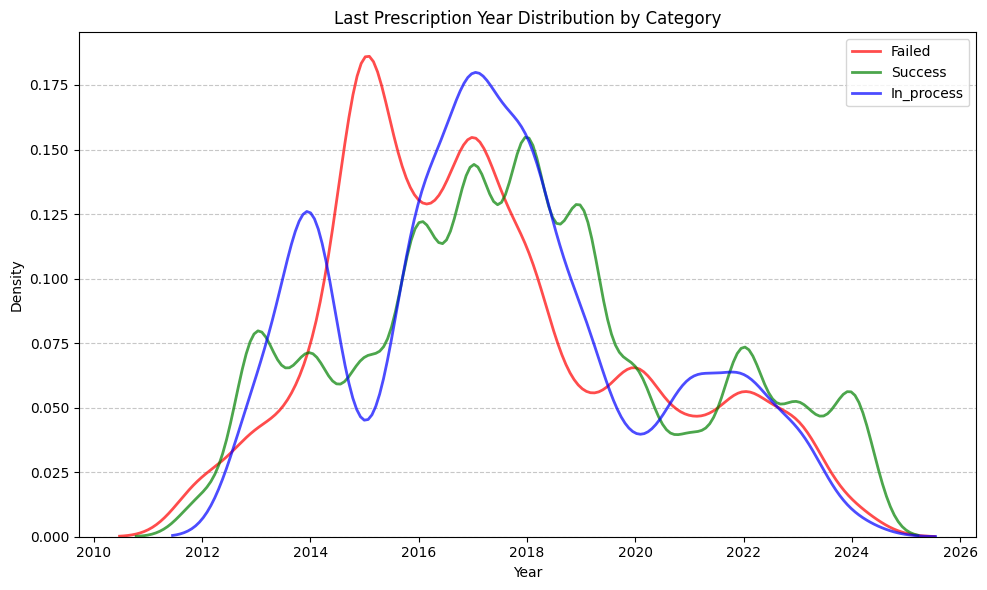

In [232]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot KDE for last prescription years without fill
def plot_last_prescription_years_kde_no_fill(last_prescription_years):
    plt.figure(figsize=(10, 6))

    # Define colors for each category
    colors = {
        "failed": "red",
        "success": "green",
        "in_process": "blue"
    }

    # Plot KDE for each category without fill
    for category, years in last_prescription_years.items():
        if years:
            sns.kdeplot(
                years, 
                bw_adjust=0.5,  # Bandwidth adjustment for smoother curves
                label=category.capitalize(), 
                color=colors[category], 
                alpha=0.7,  # Adjust transparency of the line
                linewidth=2  # Line thickness for better visibility
            )

    # Add labels, legend, and title
    plt.xlabel("Year")
    plt.ylabel("Density")
    plt.title("Last Prescription Year Distribution by Category")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Call the function after the classification process
plot_last_prescription_years_kde_no_fill(last_prescription_years)
